## **MORPHOLOGICAL ANALYSER FOR MONGOLIAN**
 ( A.Lkhagvadorj 17B1NUM2406, 2021, 04)

---



This notebook trains a sequence to sequence (seq2seq) model with attention for Mongolian morpholigical  analyser.

After training the model in this notebook, it will be able to extract word as "source + inflection" as shown below

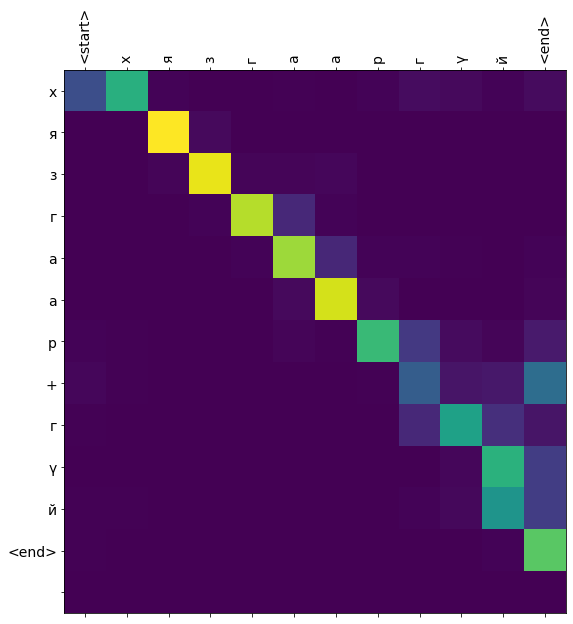

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import pandas as pd

import unicodedata
import re
import numpy as np
import os
import io
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import and prepare dataset
 Dataset has formatted in other notebook and look like this :

 ```
хязгааргүй, хязгаар + гүй
```

steps :
1. Split every character of a word and then add start and end to every row of data (every word)
2. Tokenize words
3. Pad each tokenized word to a maximum length.

In [ ]:
def preprocess_sentence(w):  
  # creating a space between a word and the punctuation following it
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
 
  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
# Return word pairs
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[1:num_examples]]

  return zip(*word_pairs)

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  inp_lang, targ_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  # print('####################################  test')
  # for i in range(1000, 1005):
  #   print('encoder -->', inp_lang[i])  
  #   print('decoder -->', targ_lang[i])
  
  # print('####################################  test 2')
  # for i in range(1000, 1005):
  #   print(input_tensor[i])  
  #   print(target_tensor[i])


  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### See test data 

In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

### Load dataset, prepare and tokenize 

In [ ]:
excel = pd.read_csv( "final.tsv", "\t", header = 0 )
data = pd.DataFrame(excel, columns = ['input', 'output'] )

num_examples = len(data)
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset("final.tsv", num_examples)
# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor), len(target_tensor))
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

# Test
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[3])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[3])

38127 38127
30501 30501 7626 7626
Input Language; index to word mapping
2 ----> <start>
24 ----> з
1 ----> а
7 ----> р
4 ----> л
1 ----> а
6 ----> г
1 ----> а
3 ----> <end>

Target Language; index to word mapping
2 ----> <start>
25 ----> з
1 ----> а
9 ----> р
4 ----> +
6 ----> л
1 ----> а
8 ----> г
1 ----> а
3 ----> <end>


### Create a tf.data dataset

In [ ]:
# BUFFER_SIZE = len(input_tensor_train)
BUFFER_SIZE = 30501
BATCH_SIZE = 128
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 19]), TensorShape([128, 21]))

In [ ]:
print(len(input_tensor_train))
print(inp_lang.word_index)
print(len(inp_lang.word_index))

30501
{'а': 1, '<start>': 2, '<end>': 3, 'л': 4, 'э': 5, 'г': 6, 'р': 7, 'у': 8, 'о': 9, 'и': 10, 'н': 11, 'д': 12, 'т': 13, 'х': 14, 'й': 15, 'с': 16, 'ө': 17, 'м': 18, 'ү': 19, 'в': 20, 'ц': 21, 'ч': 22, 'б': 23, 'з': 24, 'ж': 25, 'ш': 26, 'ы': 27, 'я': 28, 'е': 29, 'ь': 30, 'к': 31, 'ё': 32, 'ъ': 33, 'п': 34, 'ф': 35, 'ю': 36, '\xa0': 37, '-': 38, '(': 39, '.': 40}
40


## Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (128, 19, 1024)
Encoder Hidden state shape: (batch size, units) (128, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (128, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (128, 19, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (128, 42)


## Define the optimizer and the loss function

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [ ]:
checkpoint_dir = '/content/drive/My Drive/hicheel/diplom/data/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
def Callback_EarlyStopping(LossList, min_delta=0.3, patience=10):
    #No early stopping for 2*patience epochs 
    if len(LossList)//patience < 2 :
        return False
    #Mean loss for last patience epochs and second-last patience epochs
    mean_previous = np.mean(LossList[::-1][patience:2*patience]) #second-last
    mean_recent = np.mean(LossList[::-1][:patience]) #last
    #you can use relative or absolute change
    # delta_abs = np.abs(mean_recent - mean_previous) #abs change
    delta_abs = np.abs(delta_abs / mean_previous)  # relative change
    if delta_abs < min_delta :
        print("*CB_ES* Loss didn't change much from last %d epochs"%(patience))
        print("*CB_ES* Percent change in loss value:", delta_abs*1e2)
        return True
    else:
        return False

In [ ]:
EPOCHS = 50

loss_list = []

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    # if batch % 100 == 0:
    #   print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
    #                                                batch,
    #                                                batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  checkpoint.save(file_prefix = checkpoint_prefix)
  
  # add loss to loss_list 
  loss_list.append( total_loss / steps_per_epoch )

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

  stopEarly = Callback_EarlyStopping(loss_list)
  if stopEarly:
    print("Early Stop signal recievet at epoch = {}".format(epoch+1) )
    break;

Epoch 1 Loss 1.1426
Time taken for 1 epoch 67.6128785610199 sec

Epoch 2 Loss 0.4086
Time taken for 1 epoch 48.028963804244995 sec

Epoch 3 Loss 0.0962
Time taken for 1 epoch 48.82953095436096 sec

Epoch 4 Loss 0.0376
Time taken for 1 epoch 48.65461587905884 sec

Epoch 5 Loss 0.0278
Time taken for 1 epoch 48.40976071357727 sec

Epoch 6 Loss 0.0219
Time taken for 1 epoch 48.56623387336731 sec

Epoch 7 Loss 0.0225
Time taken for 1 epoch 49.05870056152344 sec

Epoch 8 Loss 0.0291
Time taken for 1 epoch 49.01731324195862 sec

Epoch 9 Loss 0.0212
Time taken for 1 epoch 48.80835437774658 sec

Epoch 10 Loss 0.0131
Time taken for 1 epoch 48.805973291397095 sec

Epoch 11 Loss 0.0181
Time taken for 1 epoch 49.28279495239258 sec

Epoch 12 Loss 0.0142
Time taken for 1 epoch 48.57927083969116 sec

Epoch 13 Loss 0.0091
Time taken for 1 epoch 48.48882341384888 sec

Epoch 14 Loss 0.0080
Time taken for 1 epoch 49.1584689617157 sec

Epoch 15 Loss 0.0072
Time taken for 1 epoch 48.69665479660034 sec

Epoc

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

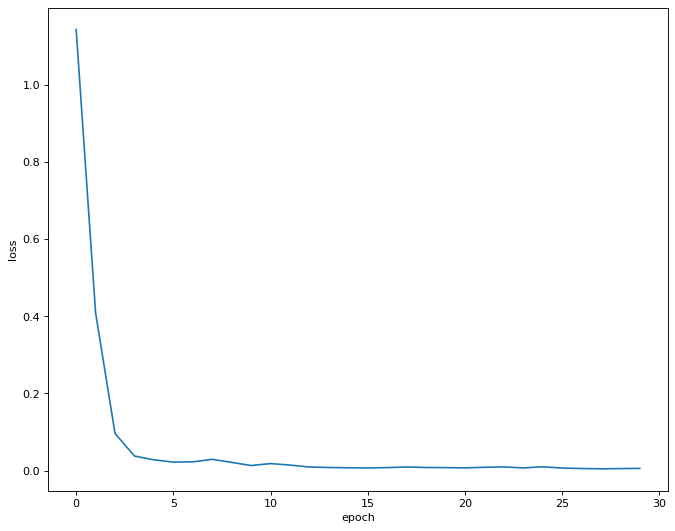

In [ ]:
plt.figure(figsize=(10, 8), dpi=80)

plt.plot(loss_list)

plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
def evaluate(sentence):
  print(sentence)
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)
  
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

ө н г ө л ө н г ө ө
Input: <start> ө н г ө л ө н г ө ө <end>
Predicted translation: ө н г ө л ө х + н г ө ө <end> 


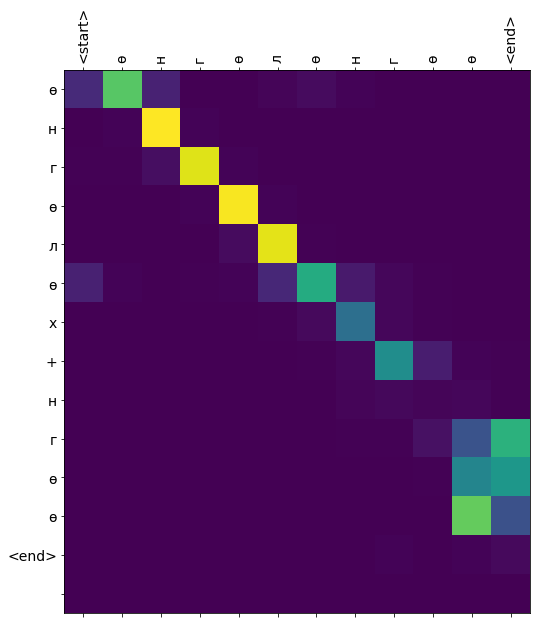

In [ ]:
translate(u'ө н г ө л ө н г ө ө')

н э р
Input: <start> н э р <end>
Predicted translation: н э р <end> 


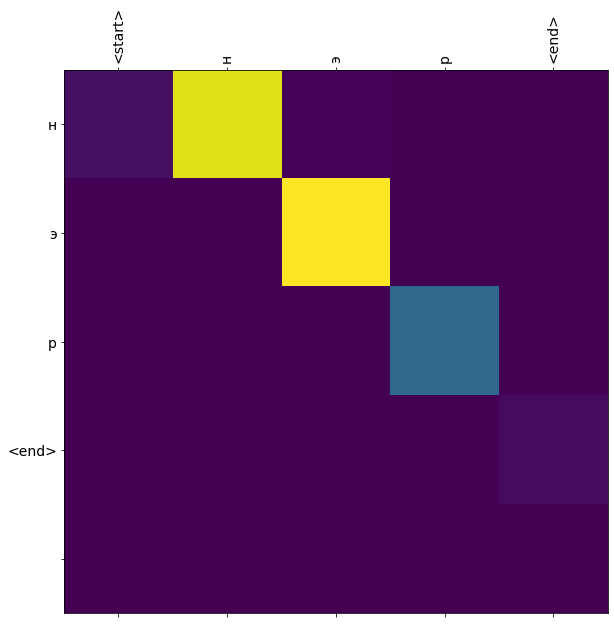

In [ ]:
translate(u'н э р')

т э т г э м ж э э р
Input: <start> т э т г э м ж э э р <end>
Predicted translation: т э т г э м ж + э э р <end> 


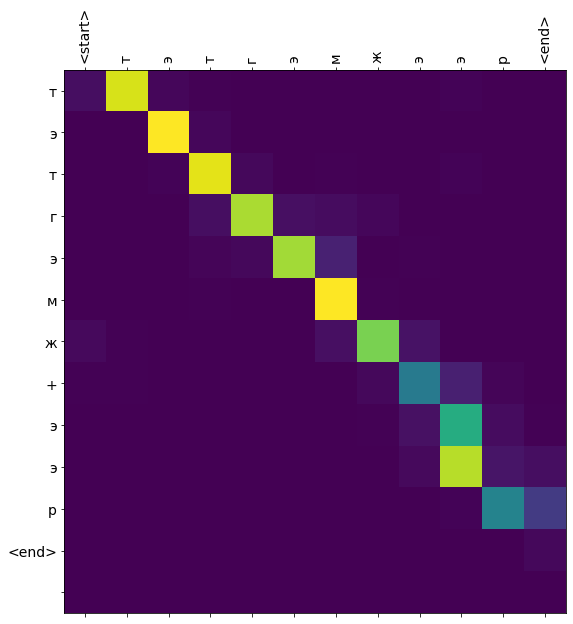

In [ ]:
translate(u'т э т г э м ж э э р')

х ү ү х д и й н
Input: <start> х ү ү х д и й н <end>
Predicted translation: х ү ү х э д + и й н <end> 


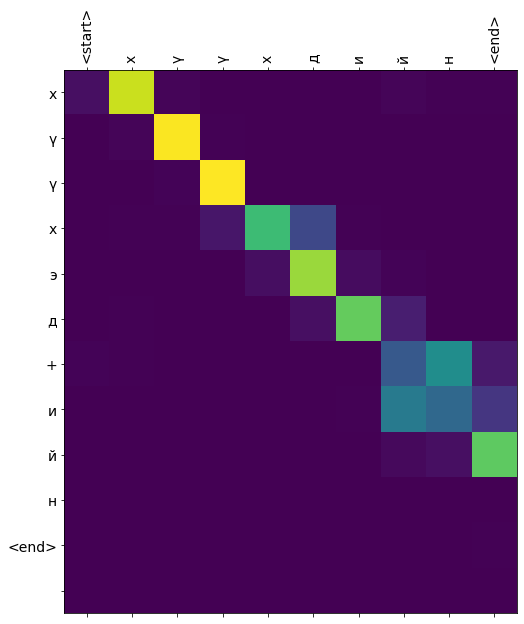

In [ ]:
translate(u'х ү ү х д и й н')

г о р х и н д
Input: <start> г о р х и н д <end>
Predicted translation: г о р х и + д <end> 


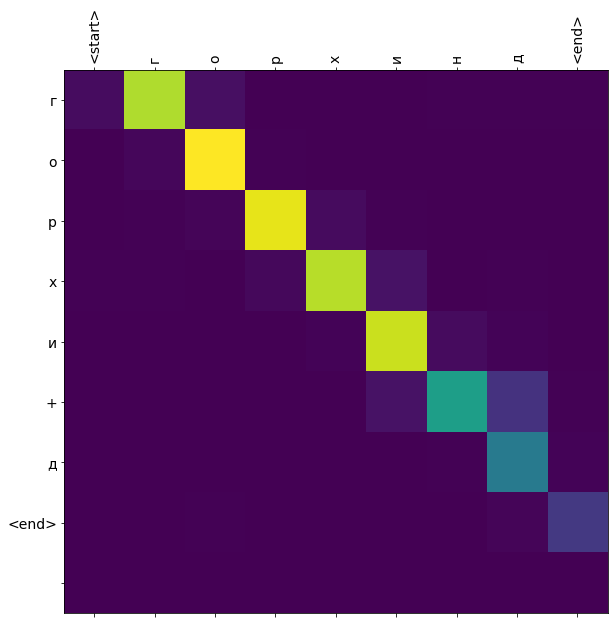

In [ ]:
translate('г о р х и н д')

т ү г д э г
Input: <start> т ү г д э г <end>
Predicted translation: т ү г э х + д э г <end> 


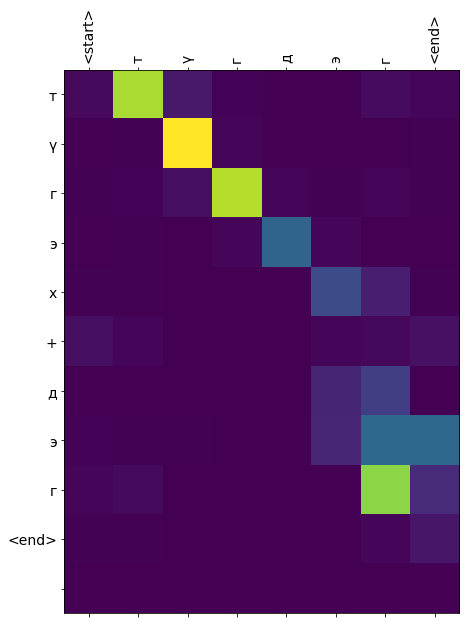

In [ ]:
translate('т ү г д э г')

# Calculate accuracy #

In [ ]:
# used to 
def getActualValue(lang, tensor):
  seq = ""
  for i in tensor:
    if i==0: return seq
    seq += lang.index_word[i] + " "

def replace(sequence):
  if sequence is None: return ''
  prefix1 = "<start> "
  prefix2 = " <end>"
  return sequence.replace(prefix1, "").replace(prefix2, "")
def compareStrings( actual, predicted ):
  if actual is None or predicted is None:
    return False
  
  actual = replace(actual)
  predicted = replace(predicted)
  return actual == predicted

In [ ]:
lost_words = []
lost_actual = []
def test_predict(inputs):
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)
  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result

def evaluate_test():
  accuracy = 0
  sum = 0
  test_data_size = len(input_tensor_val)
  for i in range(test_data_size):
    predicted_value = test_predict( input_tensor_val[i] )
    actual_value = getActualValue(targ_lang, target_tensor_val[i])
    isSame = compareStrings(actual_value, predicted_value)
    if isSame: 
      accuracy = accuracy + 1
    else:
      lost_words.append( replace(predicted_value) )
      lost_actual.append( replace(  getActualValue(inp_lang, input_tensor_val[i])  ) )
    sum += 1
  print("accuracy: ", accuracy)
  print("sum: ", sum)

evaluate_test()


accuracy:  6992
sum:  7626


In [ ]:
print(lost_words)
print(lost_actual)

['а д и г + и й н ', 'и л б э ч и н ', 'д э в т э р + л э х ', 'х и й с в э р + т ', 'з ө ө л + р ө х ', 'у л а й р с а н ', 'о р л о х + л т ', 'г а н ц а а р + д а х ', 'л у й х а р ', 'а в х у у л а х + ш г ү й ', 'б ө н д ө г + т ', 'с а а х + л ', 'х ү ү д ', 'б у в т а н + н ', 'х ү й + т э н ', 'з о г д о й н ', 'с о н с о х + у у ', 'д ү р в э г ч и д + р ү ү ', 'г я л б а х ', 'с и м ф о з и и м а х + м ', 'г а ш и х + у у н ', 'х о л б о ц ', 'у р г а ц а ц + д ', 'х э в и й н + р ү ү ', 'ү з ү ү р г ү й ', 'д у р а н + д ', 'с э т г ч и х + л ч ', 'х ү л + э э с ', 'н о т л о х + г ', 'и л э р х и й л э х + г д э х ', 'б а й ц а а х + г ч ', 'т у й л + ы г ', 'ө в ө х + л ', 'д ү р э м + и й н ', 'с э ж а б и н и н ', 'о й д ', 'ч и г э э ', 'т о р + о о с ', 'т э э х + л э х ', 'т э м т р э х + ү ү л ', 'х ү ч + и й ', 'з э в и й н + р ү ү ', 'х у в ь с г а х + л ', 'г а ш у у д а л + т а й ', 'п и в о + о р ', 'б а л а р + т а х ', 'с у р г а х + и й г ', 'б э л + д э х ',

In [ ]:
import file_service as fl

In [ ]:
file_name = 'words.tsv'
columns = [ 'word_id', 'lemma', 'POS', 'Category', 'Derivation', 'Source word', 'Derivation POS', 'Source POS', 'Inflection' ]
all_words = fl.read_file( file_name, columns, '\t', 0, True)


file_name = 'mn-noun.tsv'
noun_words = fl.read_file( file_name, None, '\t', 0 )

file_name = 'mn-verb-new.csv'
verb_words = fl.read_file( file_name, None, '\t', 0 )
  

In [ ]:
def searchFromAllWord(word):
  for index, row in all_words.iterrows():
    if word == row[1]:
      pos = row[2].split(';')
      return pos[0]

def searchFromNoun(word):
  for index, row in noun_words.iterrows():
    if word == row[1]:
      return row[0]

def searchFromVerb(word):
  for index, row in verb_words.iterrows():
    if word == row[1]:
      return row[0]

In [ ]:
def getPosition(word):
  pos = searchFromAllWord(word)
  if pos is None:
    noun = searchFromNoun(word)
    if noun is None:
      verb = searchFromVerb(word)
      if verb is not None: 
        return searchFromAllWord(verb) 
    return searchFromAllWord(noun)
  return pos

noun_pos = []
verb_pos = []
adj_pos = []
other = []

for res in lost_actual:
  pos = getPosition( res.replace(' ', '') )
  if pos is None: other.append(res)
  elif pos == 'noun': noun_pos.append(res)
  elif pos == 'verb': verb_pos.append(res)
  elif pos == 'adjective': adj_pos.append(res)
  else : other.append(res)

# print(len(result))


In [ ]:
print(len(lost_actual))
print(len(noun_pos))
print(len(verb_pos))
print(len(adj_pos))
print(len(other))

634
379
87
110
58


х и й с в э р ж и л т
Input: <start> х и й с в э р ж и л т <end>
Predicted translation: х и й с в э р + т <end> 


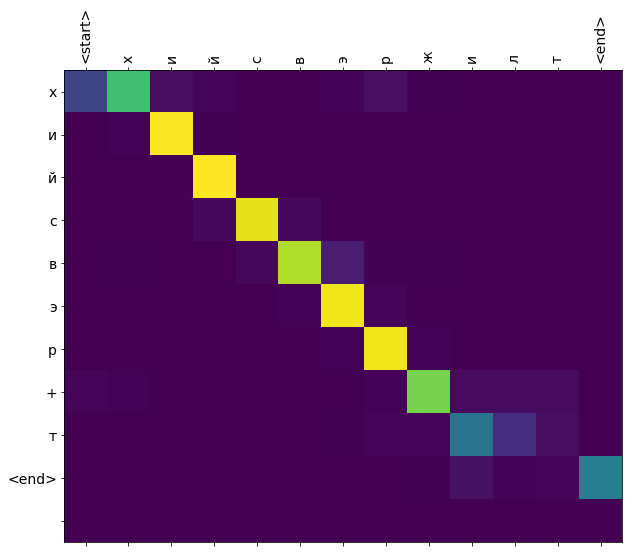

In [ ]:
# wrong translation
translate('х и й с в э р ж и л т')

а д г и й н
Input: <start> а д г и й н <end>
Predicted translation: а д и г + и й н <end> 


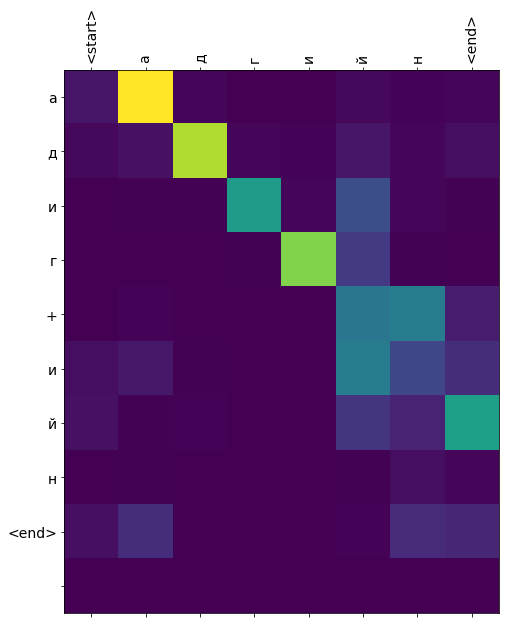

In [ ]:
# wrong translation
translate('а д г и й н')